# Lesson 0019 - MNIST Classification Convolutional Neural Network (II)
In the last [lesson](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0018_mnist_classification_convolutional_neural_network.ipynb), we created our first convolutional neural network.<br>
In this lesson, we steal the code from [last lesson](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0018_mnist_classification_convolutional_neural_network.ipynb) and create a bigger convolutional neural network hoping, that the we achieve better performance on the MNIST data set.<br>
Also, since training the model from [lesson 0018](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0018_mnist_classification_convolutional_neural_network.ipynb) took really long, we change our code, so that we evaluate the performance on the training and test set only every $100$ iterations.<br>
Also, we will have a look at what the filters in the first convolutional layer look like.

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma

In [6]:
train_y_2 = np.zeros( shape = [ 60000, 10 ] )

test_y_2 = np.zeros( shape = [ 10000, 10 ] )




for i in range( 60000 ):
    
    train_y_2[ i, train_y[ i ] ] = 1.0
    
    
for i in range( 10000 ):
    
    test_y_2[ i, test_y[ i ] ] = 1.0
    




train_y = train_y_2

test_y = test_y_2

In the last [lesson](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0018_mnist_classification_convolutional_neural_network.ipynb), the convolutional layers had $32$ filters each. We now increase this to $64$.<br>
We name the first convolutional layer __conv1__.

In [7]:


x_tf = tf.placeholder( tf.float32, shape = [ None, 28, 28, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 10 ] )




conv1 = tf.layers.conv2d( x_tf, filters = 64, kernel_size = [ 5, 5 ], name = 'conv1' )

max1 = tf.layers.max_pooling2d( conv1, pool_size = [ 2, 2 ], strides = [ 2, 2 ] )

conv2 = tf.layers.conv2d( max1, filters = 64, kernel_size = [ 5, 5 ] )

max2 = tf.layers.max_pooling2d( conv2, pool_size = [ 2, 2 ], strides = [ 2, 2 ])

flat = tf.layers.flatten( max2 )





W_tf = tf.Variable( tf.truncated_normal( [ 1024, 10 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 10 ] ) )

output = tf.nn.leaky_relu( tf.matmul( flat, W_tf ) + b_tf )




cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( logits = output, labels = y_tf ) )




gd = tf.train.GradientDescentOptimizer( 0.001 ).minimize( cross_entropy )



hit = tf.equal( tf.argmax( output, 1 ), tf.argmax( y_tf, 1 ) )



accuracy = 100 * tf.reduce_mean( tf.cast( hit, tf.float32 ) )



Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


As stated above, we want to reduce the time for training by evaluating the performance only every $100$. Therefore, we introduce the list __progress_iterations__ to store the iteration number and an __if clause__ that checks whether the current iteration can be divided by $100$.<br>
We also have to split up the evaluation of the complete training set into $6$ chunks to avoid problems with the memory (at least on my machine).<br>
We train this model for $200000$ iterations with $100$ randomly drawn training data and a learning rate of $0.001$.

In [8]:
sess = tf.Session()

progress_train = []

progress_train_current = []

progress_test = []

progress_iterations = []

test_performance_buffer = []




train_x_r = np.reshape( train_x, newshape = [ 60000, 28, 28, 1 ] )

test_x_r = np.reshape( test_x, newshape = [ 10000, 28, 28, 1 ] )
 
    
    
sess.run( tf.global_variables_initializer() )
        
for i in range( 200000 ):
                
    random_integers = np.random.choice( range( 60000 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    local_x = np.reshape( local_x, newshape = [ 100,28, 28, 1 ] )
        
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y } )
    
    if( ( i % 100 ) == 0 ):
        
        for j in range(6):
            
            test_performance_buffer.append( 
                sess.run( accuracy, feed_dict = { x_tf : train_x_r[ ( j * 10000 ) : ( ( j + 1 ) * 10000 ), :, :, : ],
                                                 y_tf : train_y[ ( j * 10000 ) : ( ( j + 1 ) * 10000 ), : ] } ) )
            
        progress_train.append( np.mean( test_performance_buffer ) )
        
        test_performance_buffer = []
        
        progress_train_current.append( sess.run( accuracy, feed_dict = { x_tf : local_x, y_tf : local_y } ) )
        
        progress_test.append( sess.run( accuracy, feed_dict = { x_tf : test_x_r, y_tf : test_y } ) )
        
        progress_iterations.append( i )

Text(0, 0.5, 'Accuracy (%)')

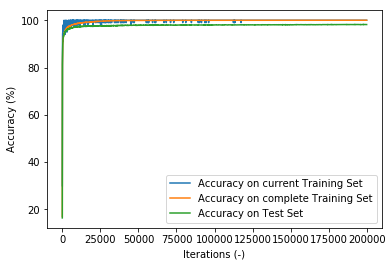

In [9]:
plt.plot( progress_iterations, progress_train_current, label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations, progress_train, label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations, progress_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

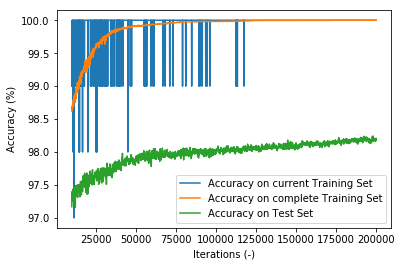

In [10]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_train_current[ 100 : 2000 ], 
         label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_train[ 100 : 2000 ], label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

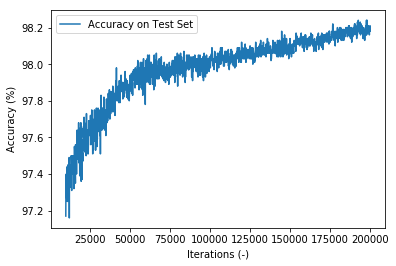

In [11]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label= 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

From the plots from above, we can deduce, that the model has learnt all the training data at iteration $125000$. Therefore, we cannot expect the model to improve any more, because once it has learnt all the data, it cannot update the weights in a meaningful way.<br>
Now, we want to have a look at the filters in the first convolutional layer.<br>
We start by querying the [trainable variables](https://www.tensorflow.org/api_docs/python/tf/trainable_variables).

In [12]:
vars = tf.trainable_variables()

Now, we print __vars__:

In [13]:
print( vars )

[<tf.Variable 'conv1/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'conv1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2d/kernel:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable:0' shape=(1024, 10) dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>]


The filters of the first convolutional layer are the first entry of the list above.<br>
We save these data into __conv1_data__ and print the format using [shape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html):

In [14]:
conv1_data = sess.run( vars[ 0 ] )

print( np.shape( conv1_data ) )

(5, 5, 1, 64)


We copy the data into a single matrix, where we leave one empty line and one empty column between every filter.<br>
For the visualization, we steal code from [lesson 0010](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0010_mnist_classification_linear_classifier.ipynb).

([], <a list of 0 Text yticklabel objects>)

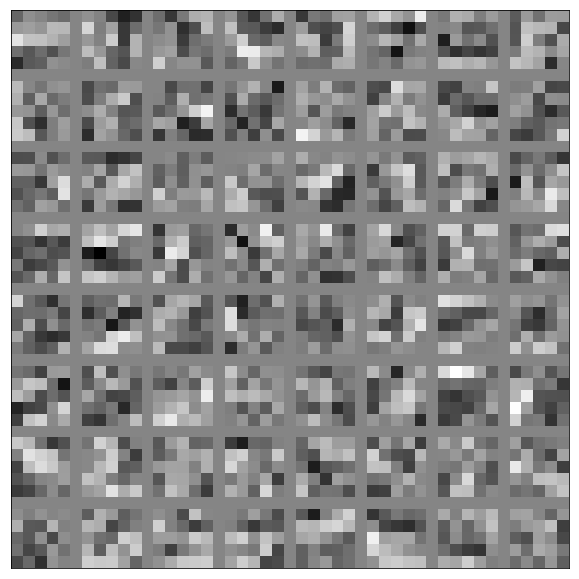

In [15]:
mat = np.zeros( shape = [ 47, 47 ] )

for i in range( 8 ):
    
    for j in range( 8 ):
        
        x_left = i * 6
        
        x_right = x_left + 5
        
        y_down = j * 6
        
        y_up = y_down + 5
        
        mat[ x_left : x_right , y_down : y_up ] = conv1_data[ :, :, 0, i * 8 + j ]
        
        
        
plt.figure( 1, figsize = ( 10, 10 ) )
        
plt.matshow( mat, cmap = plt.cm.gray, fignum = 1 )

plt.xticks( [ ] )

plt.yticks( [ ] )

It's acutally hard to interprete these filters. The second filter from the left in the top row might look for vertical lines,  the second and the third filter from the right in the top row might look for horizontal lines, the first filter from the left in the second row from the bottom might like circular shapes, but that's all just guessing.<br>
Let's save the model and close the session.

In [16]:
saver = tf.train.Saver()

saver.save( sess, 
           "C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0019\\convolutional_neural_network_64_64" )

sess.close()

Class dismissed.